In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from kalman_vect import plot_2d_gauss

We change notation for convinience 

$S = X$

$X = Z$

$\vec{X_{k+1}} = F\vec{X_{k}} + \vec{W}$

$\vec{Z_k} = H\vec{X_k} + \vec{V}$

$X_{k+1} = \begin{bmatrix}x_{k+1} \\ \dot{x_{k+1}} \end{bmatrix}$
$F = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix}$
$H = \begin{bmatrix} 1 & 0 \\ 0 & 0\end{bmatrix}$

$W = N(0,Q)$

$V = N(0,R)$

Q and R are the covariances matrices

$\begin{bmatrix}x_{k+1} \\ \dot{x_{k+1}} \end{bmatrix} = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix} \begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{W}$

${Z_k} = \begin{bmatrix} 1 & 0 \end{bmatrix}\begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{V}$

if $\dot{x_k} = 1$ and $\Delta{t} = 1$

Same problem

## Generative model

In [7]:
def generate_data(X_0 = np.array([0,1]), ):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-7-941514bd6d48>, line 2)

## Update (Multiplication or N dimensional normal pdfs)

https://www.cs.nyu.edu/~roweis/notes/gaussid.pdf

$N(c,C) = \alpha N(a,A)N(b,B) $

$ C = (A^{-1} + B^{-1})^{-1}$

$ c = CA^{-1}a + CB^{-1}b$

In [8]:
def gauss_pdfs_mult(a,A,b,B):
    A_1 = np.linalg.inv(A)
    B_1 = np.linalg.inv(B)
    C = np.linalg.inv(A_1 + B_1)
    c = C.dot(A_1).dot(a) + C.dot(B_1).dot(b)
    return c, C

### Example

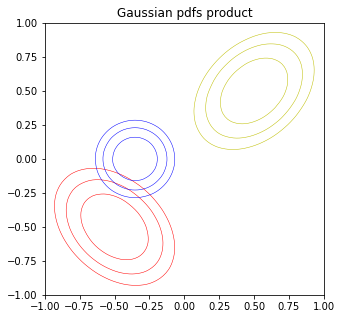

[-0.3535  0.    ]


In [9]:
plt.figure(figsize = (5,5))  

zero_mean = np.array([-0.5 , -0.5])
R = np.array([[1, -0.707],[0 ,1]])

mu_x = np.array([0.5 , 0.5])
sigma_x = np.array([[1, 0.707],[0 ,1]])
limit = 1
plot_2d_gauss(zero_mean, R, color='r', limits = [-limit,limit, -limit,limit])
plot_2d_gauss(mu_x, sigma_x, color='y', limits = [-limit,limit, -limit,limit])

mean, P = gauss_pdfs_mult(zero_mean, R, mu_x, sigma_x)
plot_2d_gauss(mean, P, color = 'b' , limits = [-limit,limit, -limit,limit])
plt.title('Gaussian pdfs product')
plt.show()
print(mean)

### Applied to our problem

$\vec{Z_k} = H\vec{X_k} + \vec{V}$

$\large{p(X_k|Z_k) = \alpha p(Z_k|X_k)p(X_K)}$

$a = \mu_{x_k} = H^{-1}Z \quad A = HRH^T \quad b=\hat{X}_{k|k-1} \quad  B = P_{k|k-1} $ 

$C = P_{k|k} \quad c=\hat{X}_{k|k}$

$P_{k|k} = \Sigma_{X_k}^{ud} = (H^TR^{-1}H + P_{k|k-1}^{-1})^{-1}$

$\hat{X}_{k|k} = \vec{\mu_x^{ud}} = P_{k|k}[H^TR^{-1}Z+P_{k|k-1}^{-1}{\hat{X}_{k|k-1}}]$

In [152]:
def update(H, R, Z, X_est ,P_est_prior):
    H= np.array(H)
    A_1 = H.T.dot(np.linalg.inv(R)).dot(H)
    P_est_prior_inv = np.linalg.inv(P_est_prior)
    
    P_est = np.linalg.inv(A_1 + P_est_prior_inv)
    
    X_est = P_est.dot(H.T.dot(np.linalg.inv(R)).dot(Z) + P_est_prior_inv.dot(X_est))
    
    return X_est, P_est

### Example: Position  is observed but speed is not observed

In [153]:
def plot_update(H, R, Z, X_est_prior, P_est_prior, y_offset = 0.1):
    plt.figure(figsize = (12,6))  
    plot_2d_gauss(X_est_prior, P_est_prior, limits = [-limit,3*limit, -limit+y_offset,limit+y_offset], color = 'r')
    plot_2d_gauss(Z, R, limits = [-limit,3*limit, -limit+y_offset,limit+y_offset], color = 'y')

    X_est, P = update(H, R, Z, X_est_prior, P_est_prior)
    plot_2d_gauss(X_est, P, limits = [-limit,3*limit, -limit+y_offset,limit+y_offset], color = 'b')
    return X_est, P

[ 0.  0.]
[[ 0.83333333  0.        ]
 [ 0.          4.99750125]]


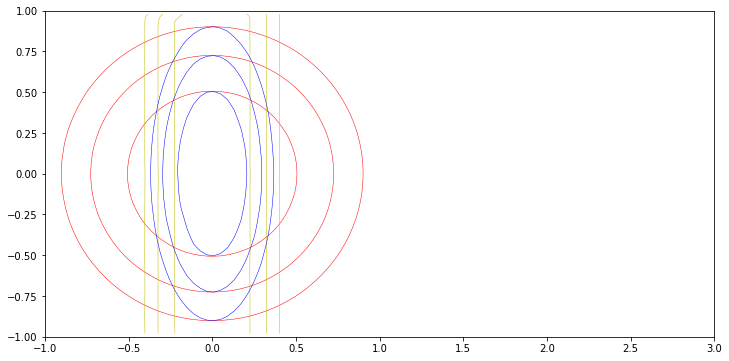

In [157]:
initial_speed_guess = 0
H = np.array([[1, 0],[0,1]])
# a priori estimates
X_est_prior = np.array([0 , initial_speed_guess])
P_est_prior = np.array([[5, 0],[0 ,5]])

# I quite know my position but not my speed then variance -> infinite
R = np.array([[1, 0],[0 ,10000]])
Z = H.dot(X_est_prior)
X_est_u, P_est_u = plot_update(H, R, Z, X_est_prior, P_est_prior, y_offset = initial_speed_guess)
print(X_est_u)
print(P_est_u)

## Prediction (Independent random vectors linear combination)

$E[A\vec{X} + \vec{Y}] = AE[\vec{X}]+E[\vec{Y}]$

$\Sigma_{AX+Y} = A\Sigma_{X}A^T + \Sigma_{Y}$

### Applied

$\vec{X_{k+1}} = F\vec{X_{k}} + \vec{W}$

$\hat{X}_{k+1} = F\hat{X}_{k}$

$P_{k+1} = FP_{k}F^T + Q$

$\begin{bmatrix}x_{k+1} \\ \dot{x_{k+1}} \end{bmatrix} = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix} \begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{W}$

$\hat{x_{k+1}} = \hat{x_{k}} + \Delta t \dot{X_k}$

In [22]:
def predict(F, mu_x, sigma_x, Q):
    X_est = F.dot(mu_x)
    P = F.dot(sigma_x).dot(F.T) + Q
    return X_est, P

[[1 1]
 [0 1]]
[ 0.5  0.5]


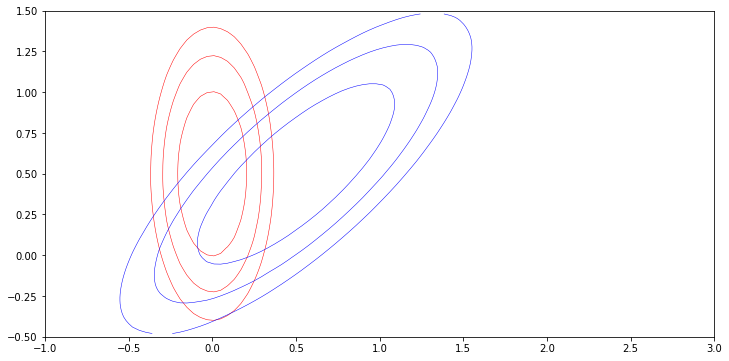

In [23]:
def plot_prediction(F, mu_x, sigma_x, Q, y_offset = 0.1):
    mu_w = np.array([0,0])
    plt.figure(figsize = (12,6))  
    plot_2d_gauss(mu_x, sigma_x, limits = [-limit,3*limit, -limit+y_offset,limit+y_offset], color = 'r')
    #plot_2d_gauss(mu_w, Q, limits = [-limit,3*limit, -limit+y_offset,limit+y_offset], color = 'y')

    mu_x, sigma_x = predict(F, mu_x, sigma_x, Q)
    plot_2d_gauss(mu_x, sigma_x, limits = [-limit,3*limit, -limit+y_offset,limit+y_offset], color = 'b')
    return mu_x, sigma_x

#sigma_x = np.array([[1, 0],[0 ,10000]])

F = np.array([[1, 1],[0,1]])
print(F)
# speed variance = infinite
Q = np.array([[1, 0],[0 , 1]])

X_est_p, P_est_p  = plot_prediction(F, X_est_u, P_est_u, Q, y_offset = initial_speed_guess)
print(X_est_p)

[ 0.5  0.5]


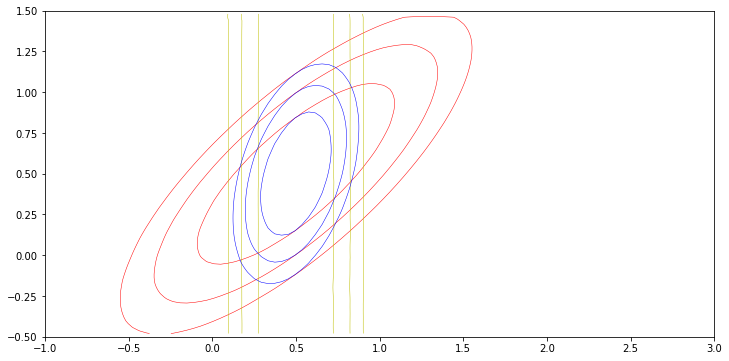

In [127]:
mu_x_uu, sigma_x_uu = plot_update(H, mu_x_p, sigma_x_p, R,y_offset = initial_speed_guess)
print(mu_x_uu)

[ 1.   0.5]


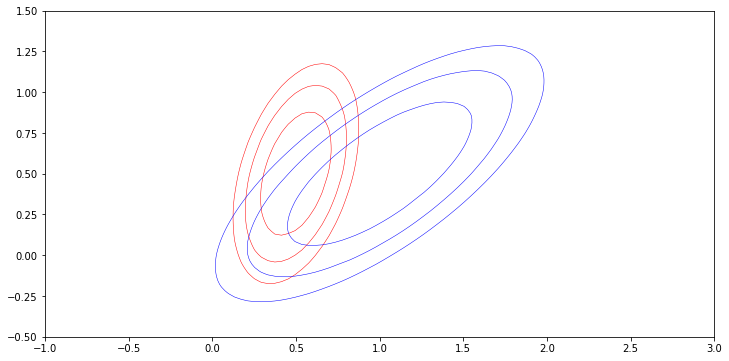

In [128]:
mu_x_pp, sigma_x_pp  = plot_prediction(F, mu_x_uu, sigma_x_uu, Q, y_offset = initial_speed_guess)
print(mu_x_pp)

[ 0.5  0.5]


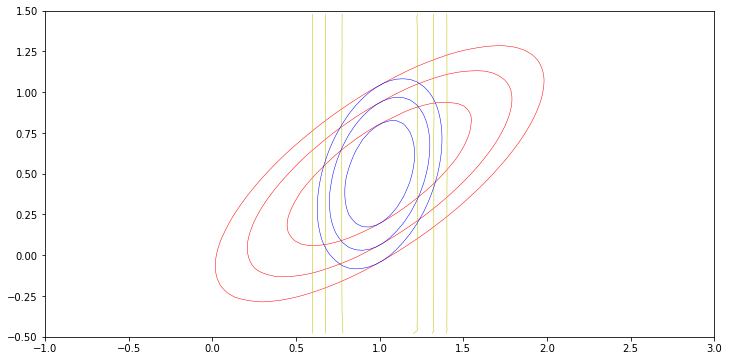

In [129]:
mu_x_uuu, sigma_x_uuu = plot_update(H, mu_x_pp, sigma_x_pp, R,y_offset = initial_speed_guess)
print(mu_x_uu)

$\begin{bmatrix}x_{k+1} \\ \dot{x_{k+1}} \end{bmatrix} = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix} \begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{W}$

${Z_k} = \begin{bmatrix} 1 & 0 \end{bmatrix}\begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{V}$

In [164]:
# a priori estimates
X_est = np.array([0.1 , 0.1]).reshape(2,1)
P_est = np.array([[1, 0],[0, 1]])
H = np.array([[1, 0],[0,1]])
H = np.array([1, 0]).reshape(1,2)

Z = H.dot(X_est)
R = np.array([[1, 0],[0, 10000]])
R = np.array([[1]])

mu_x, sigma_x = update(H, R, Z, X_est ,P_est)
print(mu_x)

[[ 0.1]
 [ 0.1]]


In [220]:
[[ 0.09558081  0.08169192]
 [ 0.08169192  0.09558081]]

SyntaxError: invalid syntax (<ipython-input-220-7c270b881991>, line 1)

In [ ]:
sigma_x = np.array([[5, 0],[0 ,5]])

R = np.array([[1, 0],[0, 1]])
Q = np.array([[1, 0],[0, 1]])
F = np.array([[1, 1],[0, 1]])

#print(update(H, R, sigma_x, mu_x))
#plot_update(H, mu_x, sigma_x, R, y_offset = 0.1)
for i in range(1):
    print(mu_x)
    #print(sigma_x[0,0])
    mu_x, sigma_x = update(H, R, sigma_x, mu_x)
    print(mu_x)
    #mu_x, sigma_x = predict(F, mu_x, sigma_x, Q)
    #print(mu_x)